MUPETALKS
=====

- Preciso pegar o dataset do MUPE e fazer um recorte nele seguindo algumas regras.
- As regras são essencialmente ditadas pelo paper de referência: [DailyTalk](https://arxiv.org/abs/2207.01063).

### Regras de recorte:
1. Pegar somente pessoas falantes de SP capital;
2. Como o início das entrevistas no MUPE contêm dados sensíveis, foi discutido para começar um pouco pra frente pra garantir anonimidade. Talvez esta anonomidade tenha que ser refinada manualmente;
3. 

### Datasets
- MUPE-ASR: [CORAA-MUPE-ASR | HuggingFace](https://huggingface.co/datasets/nilc-nlp/CORAA-MUPE-ASR): $\approx 41.8 \text{ GB}$
    - train: 277k
    - test: 10k
    - validation: 31k
- Metadata: [Google Sheets | Metadata](https://docs.google.com/spreadsheets/d/1_gg2bL8TbIbqarlR3sfthMzGTiANvJis/edit?gid=1202708851#gid=1202708851)

### References

- To create an audio corpus: [HuggingFace](https://huggingface.co/docs/datasets/audio_dataset)


## Considerations

- `birth_state == Null`

    Where the `birth_country != 'Brasil'` the states are `Null`

    ```
    birth_country
    Brasil       272
    Portugal       4
    Chile          4
    Alemanha       3
    Argentina      2
    Nigéria        1
    Japão          1
    Mónaco         1
    Itália         1
    Name: count, dtype: int64
    ```



# Imports

In [1]:
import re
import os
import difflib
from enum import Enum
from pathlib import Path
from typing import List, Tuple, cast

import rich
import datasets
import numpy as np
import pandas as pd
from google import genai 
# from dotenv import load_dotenv
from google.genai import types
from datasets import Audio
import matplotlib.pyplot as plt
from pydantic import BaseModel, Field
from IPython.display import Audio as ipyAudio

NOTEBOOKS_PATH = Path.cwd()
DATASETS_PATH = NOTEBOOKS_PATH / "datasets"
MUPE_GIT_PATH = DATASETS_PATH / "coling-mupe-asr"
assert all([DATASETS_PATH.exists(), MUPE_GIT_PATH.exists()])

# Audio(filename="./file_example_WAV_1MG.wav")
# os.environ["VERTEX_AI_API_KEY"], os.environ["GEMINI_API_KEY"]

/home/antonio-moreira/Documents/my-masters-degree/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Opening train dataset

In [2]:
mupe_train = pd.read_csv(MUPE_GIT_PATH / "train.csv")
mupe_train.head(2)

,audio_id,audio_name,file_path,speaker_type,speaker_code,speaker_gender,audio_quality,start_time,end_time,duration,normalized_text,original_text
0,859,pc_ma_hv064,train/pc_ma_hv064/pc_ma_hv064_0_6.69_8.37.wav,P/2,MA108,F,high,6.693,8.374,1.681,ponto de cultura museu aberto,"Ponto de Cultura, Museu Aberto."
1,859,pc_ma_hv064,train/pc_ma_hv064/pc_ma_hv064_5_26.53_27.87.wav,P/1,ADC052,F,high,26.528,27.869,1.341,bom dia professor,"Bom dia, professor."


In [5]:
# Getting some statistics from `mupe_train`

# rows
num_rows = mupe_train.shape[0]
# number of uniques `audio_name` and `audio_id`
num_unique_audio_names = mupe_train['audio_name'].nunique()
num_unique_audio_ids = mupe_train['audio_id'].nunique()

print(f"Number of rows: {num_rows}"
      f"\nNumber of unique audio names: {num_unique_audio_names}"
      f"\nNumber of unique audio IDs: {num_unique_audio_ids}"
)

Number of rows: 276881
Number of unique audio names: 250
Number of unique audio IDs: 250


## A sample

In [5]:
' '.join(mupe_train[mupe_train['audio_id'] == 859]['normalized_text'].astype(str))

'ponto de cultura museu aberto bom dia professor estamos aqui no museu da cultura hoje é dia vinte e seis de setembro de dois mil e sete professor para começar eu gostaria que o senhor dissesse o seu nome completo data e local de nascimento nasci no dia trinta e um de maio de mil novecentos e cinquenta e dois numa cidade do interior joanópolis depois por volta de dez anos então vim para são paulo e estou até hoje em são paulo qual o nome do seu pai e da sua mãe eh quantos irmãos nós somos em sete irmãos sendo quatro homens e três mulheres entre o meu irmão mais velho e eu que sou caçula da dos sete nós temos uma diferença de vinte e cinco anos todos ainda todos ainda vivos o que o que o senhor sabe sobre a origem da sua família bom uma origem humilde não chegaram a ter essa oportunidade do estudo ainda na na época em que nasci o estudo ainda era uma coisa ou para quem morava na cidade ou para gente rica né quer dizer um colírio melhor a pessoa que morava num sítio como é num sítio numa

# Processing Metadata

In [41]:
mupe_metadata = pd.read_csv("/home/antonio-moreira/Documents/my-masters-degree/notebooks/datasets/CORAA-MUPE/TESTE_DEV_TRAIN_mupe_metadados_289.xlsx - df_full6.csv", sep=',')
mupe_metadata.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/antonio-moreira/Documents/my-masters-degree/notebooks/datasets/CORAA-MUPE/TESTE_DEV_TRAIN_mupe_metadados_289.xlsx - df_full6.csv'

In [8]:
def preprocess_metadata_dataset(df:pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df[df['birth_country'] == 'Brasil']
    df = df[['split', 'braz_id', 'mupe_code', 'interviewee_name',
       'youtube_link', 'interviewer1', 'interviewer2', 'interviewer3', 'title',
       'gender', 'birth_state', 'interviewee_bio']]
    df = df.rename(columns={'braz_id': 'audio_id'})
    print(f"Number of rows with NA in 'audio_id': {df['audio_id'].isna().sum()}")
    df = df.dropna(subset=['audio_id'])
    df['audio_id'] = df['audio_id'].astype(int)
    return df

In [9]:
mupe_metadata = preprocess_metadata_dataset(mupe_metadata)
mupe_metadata.head()

Number of rows with NA in 'audio_id': 0


,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio
0,test,901,PC_MA_HV169,Patricia Santos Souza,https://www.youtube.com/watch?v=non3ULc83pA,Ricardo Pedroni,Mariana Casellato,NaN,Paixão e movimento na grande São Paulo,Feminino,Sergipe,"Patricia Santos Souza nasceu em 1981, em Sergi..."
1,dev,31,PC_MA_HV003,Simone Mattos de Alcântara Pinto,https://www.youtube.com/watch?v=EAcPf_JhR_4,Maria Lenir Justo,Laura Olivieri,NaN,Dança entre memórias,Feminino,São Paulo,Simone Mattos de Alcântara Pinto nasceu em São...
2,train,859,PC_MA_HV064,Durval Bueno,https://www.youtube.com/watch?v=mpnW-41UnYk,Aparecida da Cruz,Marta Alves,NaN,A educação vale a pena,Masculino,São Paulo,"Durval Bueno nasceu em Joanópolis, cidade do i..."
3,train,423,PC_MA_HV024,Wagner Pinheiro,https://www.youtube.com/watch?v=pYkYxbdMtYg,Emílio Cordeiro,Patrícia Fortunato,NaN,Professor de ideias,Masculino,São Paulo,O professor Wagner ingressou na PUC no ano de ...
4,train,505,PC_MA_HV235,Roberta de Oliveira,https://www.youtube.com/watch?v=BPreRmzA03E,Marta Dellelis,Isabela de Arruda,NaN,Pérola rara no viver e no cantar,Feminino,São Paulo,"Filha de pais separados, Roberta logo cedo con..."


In [10]:
mupe_metadata[mupe_metadata['birth_state'].isna()]

,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio


In [11]:
mupe_metadata_sp = mupe_metadata[mupe_metadata['birth_state'].str.contains('Paulo')].reset_index(drop=True)
print(mupe_metadata_sp.shape)
mupe_metadata_sp.head()

(167, 12)


,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio
0,dev,31,PC_MA_HV003,Simone Mattos de Alcântara Pinto,https://www.youtube.com/watch?v=EAcPf_JhR_4,Maria Lenir Justo,Laura Olivieri,NaN,Dança entre memórias,Feminino,São Paulo,Simone Mattos de Alcântara Pinto nasceu em São...
1,train,859,PC_MA_HV064,Durval Bueno,https://www.youtube.com/watch?v=mpnW-41UnYk,Aparecida da Cruz,Marta Alves,NaN,A educação vale a pena,Masculino,São Paulo,"Durval Bueno nasceu em Joanópolis, cidade do i..."
2,train,423,PC_MA_HV024,Wagner Pinheiro,https://www.youtube.com/watch?v=pYkYxbdMtYg,Emílio Cordeiro,Patrícia Fortunato,NaN,Professor de ideias,Masculino,São Paulo,O professor Wagner ingressou na PUC no ano de ...
3,train,505,PC_MA_HV235,Roberta de Oliveira,https://www.youtube.com/watch?v=BPreRmzA03E,Marta Dellelis,Isabela de Arruda,NaN,Pérola rara no viver e no cantar,Feminino,São Paulo,"Filha de pais separados, Roberta logo cedo con..."
4,train,501,PC_MA_HV238,Vânia Bure,https://www.youtube.com/watch?v=IUl-xIuwKWk,Nadia Lopes de Camargo,Fernanda Prado,NaN,Defensora dos direitos da população em Mauá,Feminino,São Paulo,Vânia nasceu em 12 de janeiro de 1967 em Lucél...


In [15]:
def get_gender_map(names:List[str]):
    #TODO
    # assert that every element in names is a string

    #single_input = isinstance(names, str)
    # name_list = [names] if single_input else [n for n in names if isinstance(n, str) and n.strip()]
    # if not name_list:
    #     return 'Unknown' if single_input else {}

    formatted_names = "\n".join(f"- {name}" for name in names)
    prompt = (
        "Classifique cada nome brasileiro listado abaixo como Masculino, Feminino ou Unknown. "
        'Responda somente com JSON no formato '
        '[{"name": "Nome", "gender": "Masculino|Feminino|Unknown"}, ...].\n\n'
        f"Nomes:\n{formatted_names}"
    )

    response: types.GenerateContentResponse = GeminiClient.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt,
        config=types.GenerateContentConfig(
            temperature=0.2, 
            response_mime_type="application/json",
            response_json_schema={'name': 'Name', 'gender': 'Masculino|Feminino|Unknown'})
    )
    
    #TODO check if the parsed is well formed
    # List[{"name": str, "gender": str}]
    parsed = response.parsed
    assert isinstance(parsed, list)

    gender_map = {i['name']: i['gender'] for i in parsed}
    return gender_map

def rank_name_similarity(target: str, candidates: List[str]) -> List[Tuple[str, float]]:
    target_norm = target.strip().casefold()
    scores = []
    for name in candidates:
        cand_norm = name.strip().casefold()
        ratio = difflib.SequenceMatcher(None, target_norm, cand_norm).ratio()
        scores.append((name, ratio))
    scores.sort(key=lambda item: item[1], reverse=True)
    best_candidate = scores[0]
    return best_candidate[0]

def infer_gender_from_map(name: str, gender_map: dict):
    key_name = rank_name_similarity(name, list(gender_map.keys()))
    return gender_map.get(key_name, 'Unknown')


# name_gender_map = get_gender_map(mupe_metadata['interviewee_name'].tolist())

# mupe_metadata['interviewee_gender'] = mupe_metadata['interviewee_name'].map(
#     lambda person: infer_gender_from_map(person, name_gender_map)
# )

In [16]:
name_gender_map = get_gender_map(mupe_metadata_sp['interviewer1'].tolist())

mupe_metadata_sp['interviewer1_gender'] = mupe_metadata_sp['interviewer1'].map(
    lambda person: infer_gender_from_map(person, name_gender_map)
)

In [17]:
mupe_metadata_sp['interviewer2'] = mupe_metadata_sp['interviewer2'].fillna('Unknown')
name_gender_map = get_gender_map(mupe_metadata_sp['interviewer2'].tolist())

mupe_metadata_sp['interviewer2_gender'] = mupe_metadata_sp['interviewer2'].map(
    lambda person: infer_gender_from_map(person, name_gender_map)
)

In [19]:
mupe_metadata_sp_gender_slice = mupe_metadata_sp[mupe_metadata_sp['gender'] != mupe_metadata_sp['interviewer1_gender']]
mupe_metadata_sp_gender_slice.to_csv("/home/antonio-moreira/Documents/my-masters-degree/notebooks/datasets/CORAA-MUPE/mupe_metadata_sp_gender_slice.csv", index=False)
mupe_metadata_sp_gender_slice.head()

,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio,interviewer1_gender,interviewer2_gender
1,train,859,PC_MA_HV064,Durval Bueno,https://www.youtube.com/watch?v=mpnW-41UnYk,Aparecida da Cruz,Marta Alves,NaN,A educação vale a pena,Masculino,São Paulo,"Durval Bueno nasceu em Joanópolis, cidade do i...",Feminino,Feminino
6,train,484,PC_MA_HV241,Maria Jose da Silva Carvalho,https://www.youtube.com/watch?v=XGB9q1a3EsY,Eduardo Barros Pinto,Isabela de Arruda,NaN,Não há cidadania sem luta,Feminino,São Paulo,A infância de Maria José foi marcada pelas bri...,Masculino,Feminino
9,train,461,PC_MA_HV249,Horacio Calligaris Galvanese,https://youtu.be/7BDzInfYf0o,Marta Dellelis,Isabela de Arruda,NaN,Pelo exercício da cidadania,Masculino,São Paulo,"Horácio é paulistano, nascido em 1954. Na juve...",Feminino,Feminino
13,train,481,PC_MA_HV258,Waldemar Antonio G. Saroka (Tuka),https://youtu.be/U9n68mE-Ees,Marina Galvanese,Isabela de Arruda,NaN,O Tuca da Mooca,Masculino,São Paulo,"Os avós maternos de Tuca, apelido de infância ...",Feminino,Feminino
14,train,824,PC_MA_HV188,Adriano da Silva,https://www.youtube.com/watch?v=BhHPoCTc81g,Gisele Vitor da Rocha,Mariana Casellato,NaN,Colecionador de histórias,Masculino,São Paulo,Adriano da Silva nasceu no dia três de julho d...,Feminino,Feminino


In [ ]:
mupe_metadata_sp['interviewer3'] = mupe_metadata_sp['interviewer3'].fillna('Unknown')
name_gender_map = get_gender_map(mupe_metadata_sp['interviewer3'].tolist())

mupe_metadata_sp['interviewer3_gender'] = mupe_metadata_sp['interviewer3'].map(
    lambda person: infer_gender_from_map(person, name_gender_map)
)

# Merge Train & Metadata datasets

In [3]:
mupe_metadata_sp = pd.read_csv(NOTEBOOKS_PATH / "mupe_metadata_sp_gender_slice.csv")
mupe_metadata_sp.drop(columns=['interviewer2_gender'], inplace=True)

mupe_selected_ids = mupe_metadata_sp['audio_id'].tolist()

# Total duration: 106.63130944444445
print(f"Total duration: {mupe_train[mupe_train['audio_id'].isin(mupe_metadata_sp['audio_id'])]['duration'].sum()/3600}")

mupe_metadata_sp.head(4)

Total duration: 106.63130944444445


,split,audio_id,mupe_code,interviewee_name,youtube_link,interviewer1,interviewer2,interviewer3,title,gender,birth_state,interviewee_bio,interviewer1_gender
0,train,859,PC_MA_HV064,Durval Bueno,https://www.youtube.com/watch?v=mpnW-41UnYk,Aparecida da Cruz,Marta Alves,NaN,A educação vale a pena,Masculino,São Paulo,"Durval Bueno nasceu em Joanópolis, cidade do i...",Feminino
1,train,484,PC_MA_HV241,Maria Jose da Silva Carvalho,https://www.youtube.com/watch?v=XGB9q1a3EsY,Eduardo Barros Pinto,Isabela de Arruda,NaN,Não há cidadania sem luta,Feminino,São Paulo,A infância de Maria José foi marcada pelas bri...,Masculino
2,train,461,PC_MA_HV249,Horacio Calligaris Galvanese,https://youtu.be/7BDzInfYf0o,Marta Dellelis,Isabela de Arruda,NaN,Pelo exercício da cidadania,Masculino,São Paulo,"Horácio é paulistano, nascido em 1954. Na juve...",Feminino
3,train,481,PC_MA_HV258,Waldemar Antonio G. Saroka (Tuka),https://youtu.be/U9n68mE-Ees,Marina Galvanese,Isabela de Arruda,NaN,O Tuca da Mooca,Masculino,São Paulo,"Os avós maternos de Tuca, apelido de infância ...",Feminino


It is important to document this behavior:

```python
>>> all(mupe_metadata_sp['mupe_code'].str.startswith('PC_MA_HV'))
True
```

# Sample case

- MA108: Aparecida da Cruz
- ADC052: Marta Alves
- MA_HV064: Durval Bueno

---

- Agregar entrevistadores diferentes num mesmo codigo (SOMENTE SE AS REGRAS DO **DAILYTALK** NAO FOREM VIOLADAS)
- Separar os dialogos por assunto abordado


In [37]:
s = mupe_train[mupe_train['audio_id'] == 484]

fpe = s["file_path"].str.extract(
        r"pc_ma_(?P<mupe_code>hv\d{3})_(?P<file_id>\d+)_")

fpe['file_id'] = fpe['file_id'].astype(int)

assert all(fpe['mupe_code'] == fpe['mupe_code'].iloc[0])

s["speaker_code"].value_counts().index[-1]

'EBP007'

In [11]:
def foo1():
    mupe_train_859 = mupe_train[mupe_train['audio_id'] == 859].sort_values("start_time").copy()

    print(mupe_train_859["speaker_code"].value_counts())

    #Consideration: joining all interviewers into a single can leverage dialogues with diverse speakers
    interviewers_join_code = "_".join(interviewers_codes := mupe_train_859["speaker_code"].value_counts()[1:].keys().to_list())
    mupe_train_859.loc[mupe_train_859["speaker_code"].isin(interviewers_codes), 'speaker_code'] = interviewers_join_code

    core_columns = ['file_path', 'speaker_code', 'start_time', 'end_time', 'duration', 'original_text'] #normalized_text

    block_id = (mupe_train_859["speaker_code"] != mupe_train_859["speaker_code"].shift()).cumsum()
    file_id = mupe_train_859["file_path"].str.extract(r'pc_ma_hv064_(?P<file_id>\d+)_').astype(int)

    df_agg = (
        mupe_train_859.assign(block_id=block_id, file_id=file_id)
        .groupby("block_id")
        .agg(
            file_path=("file_path", list),
            file_id=("file_id", list),
            speaker_code=("speaker_code", "first"),
            start_time=("start_time", "min"),
            end_time=("end_time", "max"),
            duration=("duration", "sum"),
            original_text=("original_text", " ".join),
        )
        .reset_index(drop=True)
    )

    file_ids = file_id['file_id'].to_numpy(dtype=int)
    missing_ids = []
    for i in range(file_ids[0], file_ids[-1]+1):
        if i not in file_ids:
            missing_ids.append(i)

    print("Missing IDs:", missing_ids)

    df_agg

In [38]:
def aggregate_sample_dialogues(mupe_df: pd.DataFrame, audio_id: int) -> tuple[pd.DataFrame, list[int], str]:
    """
    Aggregate contiguous utterances for a given audio_id and detect missing file counters.

    Returns
    -------
    tuple[pd.DataFrame, list[int], str]
        - Aggregated blocks with merged interviewer turns.
        - Sorted list of missing file_id counters.
        - The joined interviewer speaker_code.
    """
    sample = mupe_df.loc[mupe_df["audio_id"] == audio_id].sort_values("start_time").copy()

    if sample.empty:
        raise ValueError(f"No rows found for audio_id={audio_id}")

    speaker_counts = sample["speaker_code"].value_counts()
    if len(speaker_counts) > 2:
        interviewer_codes = speaker_counts.index[1:]
        join_code:str = "_".join(interviewer_codes)
        print(f"Joining interviewer codes {interviewer_codes} into '{join_code}'")
        sample.loc[sample["speaker_code"].isin(interviewer_codes), "speaker_code"] = join_code
    else:
        join_code:str = speaker_counts.index[-1]

    block_id = (sample["speaker_code"] != sample["speaker_code"].shift()).cumsum()
    
    file_path_extract = sample["file_path"].str.extract(
        r"pc_ma_(?P<mupe_code>hv\d{3})_(?P<file_id>\d+)_")
    
    #TODO log the mupe_code value
    assert all(file_path_extract['mupe_code'] == file_path_extract['mupe_code'].iloc[0]), \
        "Multiple mupe_code values found in the sample."
    
    file_id_series = file_path_extract["file_id"].astype(int)

    df_agg = (
        sample.assign(block_id=block_id, file_id=file_id_series)
        .groupby("block_id")
        .agg(
            file_path=("file_path", list),
            file_id=("file_id", list),
            speaker_code=("speaker_code", "first"),
            start_time=("start_time", "min"),
            end_time=("end_time", "max"),
            duration=("duration", "sum"),
            original_text=("original_text", " ".join),
        )
        .reset_index(drop=True)
    )

    if file_id_series.empty:
        return df_agg, [], join_code

    file_ids = file_id_series.to_numpy(dtype=int)
    expected = set(range(file_ids.min(), file_ids.max() + 1))
    missing_ids = sorted(expected.difference(file_ids))
    return df_agg, missing_ids, join_code

# Valid audios ids: 859, 484, 461
mupe_train_sample, missing_ids_sample, itvw_code = aggregate_sample_dialogues(mupe_train, audio_id=484)
# display(missing_ids_sample)
mupe_train_sample.head(3)

,file_path,file_id,speaker_code,start_time,end_time,duration,original_text
0,[train/pc_ma_hv241/pc_ma_hv241_0_18.604_22.165...,"[0, 1]",EBP007,18.604,29.231,10.627,A gente começa a nossa entrevista sempre com t...
1,[train/pc_ma_hv241/pc_ma_hv241_3_35.715_39.537...,"[3, 4]",MA_HV241,35.715,44.840,9.125,Mil novecentos e cinquenta e seis. Martinópoli...
2,[train/pc_ma_hv241/pc_ma_hv241_5_44.84_46.181....,"[5, 7]",EBP007,44.840,54.397,3.884,E o nome dos pais da senhora? Qual era a profi...


In [ ]:
s = mupe_train[mupe_train['audio_id'] == 484].copy()
s = s[s['start_time'].between(2830, 3489)]
file_path_extract = s["file_path"].str.extract(
        r"pc_ma_(?P<mupe_code>hv\d{3})_(?P<file_id>\d+)_")
file_path_extract_id = file_path_extract['file_id'].astype(int)
s = s.assign(file_id=file_path_extract_id)


# for row in s.itertuples():
#     start_time = float(row.start_time)
#     hours = int(start_time // 3600)
#     minutes = int((start_time % 3600) // 60)
#     seconds = start_time % 60
#     timestamp = f"{hours:02d}:{minutes:02d}:{seconds:05.2f}"
#     print(f"{row.file_id} - {timestamp} - {row.original_text}")

Altought we have missing ids, they are not in contiguous blocks

In [39]:
def has_missing_ids(ids: List[int]) -> tuple[list[int], int]:
    missing_ids = [i for i in range(ids[0], ids[-1] + 1) if i not in ids]
    return missing_ids, len(missing_ids)

missing_ids_result = pd.DataFrame(
    mupe_train_sample["file_id"].apply(has_missing_ids).tolist(),
    columns=["missing_ids", "missing_count"],
)

mask = missing_ids_result["missing_count"] > 0
missing_ids_result = missing_ids_result.loc[mask]

print(len(missing_ids_sample))
print(missing_ids_result['missing_count'].sum())

print(missing_ids_result.loc[91]['missing_ids'])
# # display(missing_ids_sample)
# missing_ids_sample_df = mupe_train_sample[mupe_train_sample['file_id'].apply(has_missing_ids)]

# print(
#     f"Total missing ids: {len(missing_ids_sample)} | "
#     f"Missing ids into `file_id` blocks: {missing_ids_sample_df.shape[0]}"
# )

# print(missing_ids_sample)

# missing_ids_sample_df

106
74
[676, 720, 721, 722, 723, 724, 725, 738, 739, 740, 765, 767, 768, 769, 774, 776, 782, 783, 792, 805, 809]


```python
{
    "TOPIC" : {"SEGMENT_ID": "SEGMENT_TIMESTAMP"}
}
```

In [40]:
class QuestionMetadata(BaseModel):
    id: int = Field(..., description="O ID numérico da pergunta (ex: 0, 2, 4)")
    timestamp: str = Field(..., description="O timestamp original (ex: 00:06)")

class SubSection(BaseModel):
    subtitle: str = Field(..., description="O subtítulo do roteiro (ex: IDENTIFICAÇÃO)")
    items: List[QuestionMetadata]

class Section(BaseModel):
    title: str = Field(..., description="O título principal do roteiro (ex: INTRODUÇÃO)")
    subsections: List[SubSection]

class InterviewSegmentation(BaseModel):
    segments: List[Section]

In [41]:
def split_interview_questions(sample_df: pd.DataFrame, interview_code:str) -> tuple[InterviewSegmentation, pd.DataFrame] | tuple[None, None]:
    questions_list = []
    questions_df = sample_df[sample_df["speaker_code"] == interview_code][["original_text", "start_time"]].copy()

    assert not questions_df.empty, f"No questions found for interview_code={interview_code}"

    for idx, row in questions_df.iterrows():
        questions_list.append(f"{idx} - {int(row.start_time//60):02d}:{int(row.start_time%60):02d} - {row.original_text}")

    #TODO should move the content locally?
    with open("./roteiro_entrevista.md", "r") as f:
        roteiro_entrevista_md = f.read()

    prompt = f"""
    Você é um especialista em história oral e análise de transcrições. 
    Sua tarefa é segmentar a transcrição de uma entrevista fornecida abaixo de acordo com o Roteiro de Perguntas oficial.

    REGRAS DE PROCESSAMENTO:
    1. Analise o conteúdo semântico de cada linha da transcrição para decidir a qual seção/subseção do roteiro ela pertence.
    2. Se um tema fugir do roteiro (ex: falar de faculdade na seção errada), aloque-o na seção semanticamente mais próxima (ex: faculdade -> Escola/Formação).
    3. **CRUCIAL**: Na saída, NÃO inclua o texto da pergunta. Retorne APENAS o 'id' e o 'timestamp' dentro da estrutura hierárquica correta.
    4. Mantenha a ordem cronológica original das perguntas dentro dos grupos.
    5. Não utilize caracteres de marcação Markdown (ex: #, ##, etc) nos títulos e subtítulos.

    ROTEIRO BASE:
    {roteiro_entrevista_md}

    TRANSCRIÇÃO PARA SEGMENTAR:
    {"\n".join(questions_list)}
    """

    client = genai.Client(
        vertexai=True,
        api_key=os.environ.get("VERTEX_AI_API_KEY"),
    )

    model = "gemini-3-pro-preview"
    
    generate_content_config = types.GenerateContentConfig(
        temperature=0.1,
        top_p=0.95,
        
        response_mime_type="application/json",
        response_schema=InterviewSegmentation,

        safety_settings=[
            types.SafetySetting(
                category=types.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
                threshold=types.HarmBlockThreshold.BLOCK_ONLY_HIGH,
            ),
            types.SafetySetting(
                category=types.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
                threshold=types.HarmBlockThreshold.BLOCK_ONLY_HIGH,
            ),
            types.SafetySetting(
                category=types.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
                threshold=types.HarmBlockThreshold.BLOCK_ONLY_HIGH,
            ),
            types.SafetySetting(
                category=types.HarmCategory.HARM_CATEGORY_HARASSMENT,
                threshold=types.HarmBlockThreshold.BLOCK_ONLY_HIGH,
            ),
        ]
    )

    try:
        response = client.models.generate_content(
            model=model,
            contents=[
                types.Content(role="user", parts=[types.Part.from_text(text=prompt)])
            ],
            config=generate_content_config,
        )
        
        assert isinstance((response_parsed := response.parsed), InterviewSegmentation)
        return response_parsed, questions_df
    except Exception as e:
        print(f"Erro na execução do Vertex AI: {e}")
        return None, None

In [46]:
s = """
Segmentation failed for audio_id=484 with interview_code=EBP007
Segmentation failed for audio_id=475 with interview_code=IDA013_MM057
Segmentation failed for audio_id=847 with interview_code=RDG022
Segmentation failed for audio_id=846 with interview_code=LR061_VB123
Segmentation failed for audio_id=752 with interview_code=DEL009_GN019
Segmentation failed for audio_id=394 with interview_code=DEL009_TR085
Segmentation failed for audio_id=476 with interview_code=IDA013_TB074
Segmentation failed for audio_id=842 with interview_code=SA014
Segmentation failed for audio_id=758 with interview_code=JB020_JOA093
"""

inter_code_re = re.compile(r"Segmentation failed for audio_id=(?P<audio_id>\d+) with interview_code=(?P<interview_code>[\w_+-]+)")

l = []
for line in s.strip().split("\n"):
    l.append(list(inter_code_re.match(line).groups()))

l = np.array(l, dtype=object)

df = pd.DataFrame(l, columns=['audio_id', 'interview_code'])
# df = df[df['interview_code'].isin(['EBP007', 'MD006_IDA013', 'GRS002', 'LVP011'])].sort_values("interview_code")
df

,audio_id,interview_code
0,484,EBP007
1,475,IDA013_MM057
2,847,RDG022
3,846,LR061_VB123
4,752,DEL009_GN019
5,394,DEL009_TR085
6,476,IDA013_TB074
7,842,SA014
8,758,JB020_JOA093


In [30]:
d = {row['interview_code']: row['audio_id'] for row in df.to_dict(orient='records')}

In [ ]:
def rename_file(file_path: Path, code_map: dict[str, str]) -> Path | None:
    """
    Rename a file, keeping the same parent directory.

    Parameters
    ----------
    file_path : Path
        Current path of the file.
    code_map : dict[str, str]
        Mapping from old interviewer codes to new interviewer codes.

    Returns
    -------
    Path
        The new path after renaming.
    """

    interview_file_name_re = re.compile(r"interview_segmentation_(?P<interviewer_code>\w+).json")

    if not file_path.exists():
        raise FileNotFoundError(f"Source file not found: {file_path}")
    
    interviewer_code = interview_file_name_re.match(file_path.name).group("interviewer_code")
    try:
        new_name = f"interview_segmentation_{code_map[interviewer_code]}.json"
    except KeyError:
        print(f"Interviewer code '{interviewer_code}' not found in code_map. Skipping file: {file_path}")
        return

    dest = file_path.with_name(new_name)
    file_path.rename(dest)
    print(dest)
    return dest

for file in Path("interview_segmentations").glob("interview_segmentation_*.json"):
    rename_file(file, d)

In [35]:
for audio_id in df["audio_id"]:
    json_path = Path(f"interview_segmentations/interview_segmentation_{audio_id}.json")
    assert json_path.exists(), f"File not found: {json_path}"

In [ ]:
s = "interview_segmentation_GN019.json"
new_code = 123
new_extension = "txt"
interview_file_name_re = re.compile(r"interview_segmentation_(?P<interviewer_code>\w+).(?P<extension>json)")

interview_file_name_re.sub(f"interview_segmentation_{new_code}.{new_extension}", s)

'interview_segmentation_123.txt'

In [47]:
# 80 ids in train split
# 183m to process all train samples
# 9 failed executions
# `ls *.json | wc`

for audio_id in df["audio_id"]:
    mupe_train_sample, missing_ids_sample, itvw_code = aggregate_sample_dialogues(mupe_train, audio_id=int(audio_id))
    interview_segmentation_sample, questions_df = split_interview_questions(mupe_train_sample, itvw_code)
    if interview_segmentation_sample is not None and questions_df is not None:
        segmentation_path = NOTEBOOKS_PATH / "interview_segmentations" / f"interview_segmentation_{audio_id}.json"
        segmentation_path.write_text(interview_segmentation_sample.model_dump_json(indent=2), encoding="utf-8")
        print(f"Segmentation saved for audio_id={audio_id} with interview_code={itvw_code}")
    else:
        print(f"Segmentation failed for audio_id={audio_id} with interview_code={itvw_code}")

Segmentation saved for audio_id=484 with interview_code=EBP007
Joining interviewer codes Index(['IDA013', 'MM057'], dtype='object', name='speaker_code') into 'IDA013_MM057'
Segmentation saved for audio_id=475 with interview_code=IDA013_MM057
Segmentation saved for audio_id=847 with interview_code=RDG022
Joining interviewer codes Index(['LR061', 'VB123'], dtype='object', name='speaker_code') into 'LR061_VB123'
Segmentation saved for audio_id=846 with interview_code=LR061_VB123
Joining interviewer codes Index(['DEL009', 'GN019'], dtype='object', name='speaker_code') into 'DEL009_GN019'
Segmentation saved for audio_id=752 with interview_code=DEL009_GN019
Joining interviewer codes Index(['DEL009', 'TR085'], dtype='object', name='speaker_code') into 'DEL009_TR085'
Segmentation saved for audio_id=394 with interview_code=DEL009_TR085
Joining interviewer codes Index(['IDA013', 'TB074'], dtype='object', name='speaker_code') into 'IDA013_TB074'
Segmentation saved for audio_id=476 with interview_

In [8]:
interview_segmentation_sample, questions_df_sample = split_interview_questions(mupe_train_sample, interview_code=itvw_code)

In [11]:
segmentation_path = NOTEBOOKS_PATH / "interview_segmentations" / f"interview_segmentation_{itvw_code}.json"
segmentation_path.write_text(interview_segmentation_sample.model_dump_json(indent=2), encoding="utf-8")

restored_segmentation = InterviewSegmentation.model_validate_json(
    segmentation_path.read_text(encoding="utf-8")
)

In [ ]:
class ClassLabel(str, Enum):
    INTRODUCAO = "INTRODUÇÃO"
    IDENTIFICACAO = "IDENTIFICAÇÃO"
    INFANCIA = "INFÂNCIA"
    FAMILIA = "FAMÍLIA"
    ESCOLA = "ESCOLA"
    JUVENTUDE = "JUVENTUDE"
    DESENVOLVIMENTO = "DESENVOLVIMENTO"
    TRABALHO_COMERCIO = "TRABALHO/ COMÉRCIO"
    FINALIZACAO = "FINALIZAÇÃO"

In [ ]:
def classify_questions(
    questions_parsed: InterviewSegmentation,
    inter_questions: pd.DataFrame,
    level: str | None = None,
) -> pd.DataFrame:
    """
    Attach classification columns to the questions DataFrame.

    Parameters
    ----------
    questions_parsed : InterviewSegmentation
        Parsed segmentation object.
    inter_questions : pd.DataFrame
        DataFrame with questions; its index must correspond to the parsed IDs.
    level : str | None, optional
        If "section", only adds a 'section' column.
        If "subsection", only adds a 'subsection' column.
        If None (default), adds both.

    Returns
    -------
    pd.DataFrame
        Copy of inter_questions with classification columns.
    """
    if level not in {"section", "subsection", None}:
        raise ValueError("level must be 'section', 'subsection', or None")

    id2cls: dict[int, tuple[ClassLabel, ClassLabel, str]] = {}
    for seg in questions_parsed.segments:
        for sub in seg.subsections:
            for item in sub.items:
                id2cls[item.id] = (
                    ClassLabel(seg.title),
                    ClassLabel(sub.subtitle),
                    item.timestamp,
                )

    missing = set(inter_questions.index) - set(id2cls.keys())
    if missing:
        raise ValueError(f"Unclassified question ids: {sorted(missing)}")

    df = inter_questions.copy()
    if level in (None, "section"):
        df["section"] = df.index.map(lambda i: id2cls[i][0])
    if level in (None, "subsection"):
        df["subsection"] = df.index.map(lambda i: id2cls[i][1])
    return df
    

display(interview_segmentation_sample)
#[1, 2, 3, 4, 7, 9, 14, 349, 352]

assert isinstance(interview_segmentation_sample, InterviewSegmentation) and isinstance(questions_df_sample, pd.DataFrame)

classify_questions(
    questions_parsed=interview_segmentation_sample,
    inter_questions=questions_df_sample,
    level="subsection"
)

InterviewSegmentation(segments=[Section(title='INTRODUÇÃO', subsections=[SubSection(subtitle='IDENTIFICAÇÃO', items=[QuestionMetadata(id=0, timestamp='00:06'), QuestionMetadata(id=2, timestamp='01:12'), QuestionMetadata(id=4, timestamp='01:38')]), SubSection(subtitle='FAMÍLIA', items=[QuestionMetadata(id=6, timestamp='01:42'), QuestionMetadata(id=8, timestamp='02:25'), QuestionMetadata(id=10, timestamp='03:23'), QuestionMetadata(id=12, timestamp='03:53')]), SubSection(subtitle='INFÂNCIA', items=[QuestionMetadata(id=14, timestamp='04:20'), QuestionMetadata(id=16, timestamp='04:30'), QuestionMetadata(id=18, timestamp='04:55'), QuestionMetadata(id=20, timestamp='05:00'), QuestionMetadata(id=22, timestamp='05:11'), QuestionMetadata(id=24, timestamp='05:45'), QuestionMetadata(id=26, timestamp='07:44'), QuestionMetadata(id=28, timestamp='08:16'), QuestionMetadata(id=30, timestamp='10:26'), QuestionMetadata(id=32, timestamp='11:04')]), SubSection(subtitle='ESCOLA', items=[QuestionMetadata(id=

,original_text,start_time,end_time,subsection
0,"Ponto de Cultura, Museu Aberto. Bom dia, profe...",6.693,53.441,ClassLabel.IDENTIFICACAO
2,"Qual o nome do seu pai e da sua mãe? Eh, Quant...",72.139,81.766,ClassLabel.IDENTIFICACAO
4,Todos ainda vi>,98.488,99.369,ClassLabel.IDENTIFICACAO
6,"O que, o que o senhor sabe sobre a origem da s...",102.452,105.194,ClassLabel.FAMILIA
8,"Na na sua lembrança, como eram os seus pais? S...",145.541,152.162,ClassLabel.FAMILIA
10,Ela fez o que?,203.806,204.426,ClassLabel.FAMILIA
12,E o que os seus pais faziam? Qual era a ocupaç...,233.487,237.828,ClassLabel.FAMILIA
14,"Certo. O, eh, senhor falou que eles moravam na...",260.496,269.081,ClassLabel.INFANCIA
16,E o o senhor morou lá a até que idade?,270.322,273.063,ClassLabel.INFANCIA
18,E onde vocês moravam?,295.530,296.751,ClassLabel.INFANCIA


In [ ]:
# FINALIZAÇÃO
# • Muita coisa mudou na atividade
# do comércio? O senhor poderia
# dar um exemplo?
# • E na cidade? Quais foram as
# principais mudanças?
# • Como está a família do senhor
# atualmente? Com quem o senhor
# mora?
# • O senhor continua trabalhando?
# • E, além do trabalho, o que o
# senhor gosta de fazer?
# • Qual é hoje seu maior sonho?
# • O que o senhor achou de contar
# um pouco da sua história?

,file_path,file_id,speaker_code,start_time,end_time,duration
0,[train/pc_ma_hv064/pc_ma_hv064_0_6.69_8.37.wav],[0],MA108,6.693,8.374,1.681
1,[train/pc_ma_hv064/pc_ma_hv064_5_26.53_27.87.w...,"[5, 6, 8]",ADC052,26.528,53.441,11.006
2,[train/pc_ma_hv064/pc_ma_hv064_10_57.47_64.17....,"[10, 11, 12]",MA_HV064,57.469,72.059,13.910
3,[train/pc_ma_hv064/pc_ma_hv064_13_72.14_74.60....,[13],MA108,72.139,74.601,2.462
4,[train/pc_ma_hv064/pc_ma_hv064_15_80.69_81.77....,[15],ADC052,80.685,81.766,1.081


0     18.154
1      4.028
2      0.080
3      6.084
4      0.960
       ...  
91     2.880
92     0.680
93     1.980
94     0.020
95       NaN
Length: 96, dtype: float64

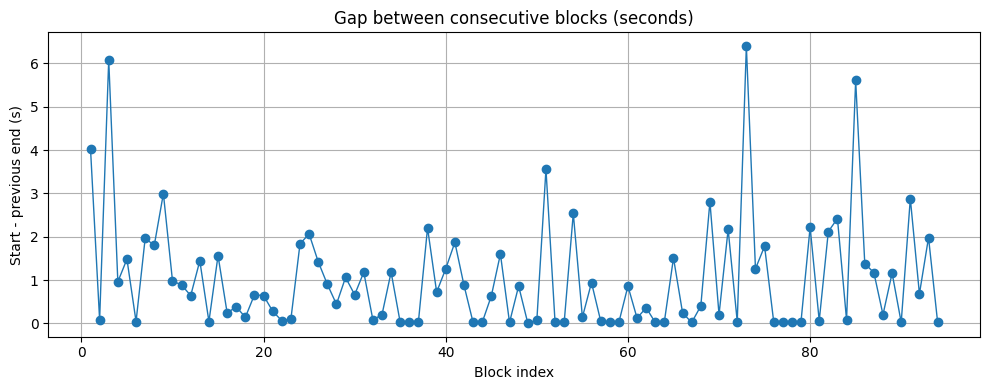

In [9]:
display(df_agg.head(5))
time_constrain = df_agg['start_time'].shift(-1) - df_agg["end_time"]
display(time_constrain)

ax = time_constrain.iloc[1:].plot(kind="line", figsize=(10, 4), marker="o", linewidth=1)
ax.set_title("Gap between consecutive blocks (seconds)")
ax.set_xlabel("Block index")
ax.set_ylabel("Start - previous end (s)")
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
tolerance_sec = 2

# The distance between the start time of the next segment and the end time of the current segment is less than the tolerance
time_constrain = (mupe_train_sample['start_time'].shift(-1) - mupe_train_sample["end_time"]) < tolerance_sec

# The speaker code of the neshpext segment is the same as the current segment
speaker_constrain = mupe_train_sample['speaker_code'] == mupe_train_sample["speaker_code"].shift(-1)

block_id = (~(time_constrain & speaker_constrain)).cumsum().shift(fill_value=0)
# block_id = (~time_constrain).cumsum().shift(fill_value=0)

df = mupe_train_sample.copy()
df_agg = (df[core_columns]
    .assign(block_id=block_id)
    .groupby('block_id')
    .agg(
        file_path=('file_path', list),
        speaker_code=('speaker_code', 'first'),
        start_time=('start_time', 'first'),
        end_time=('end_time', 'last'),
        duration=('duration', 'sum')
    ).reset_index(drop=True)
)

df_agg.shape

(130, 5)

In [ ]:
filename_pattern = re.compile(r'pc_ma_hv064_(?P<counter>\d+)_')

def extract_counter(path: str) -> int | None:
    m = filename_pattern.search(os.path.basename(path))
    return int(m.group("counter")) if m else None

df = mupe_train_sample.copy()

# df["counter"] = df["file_path"].map(extract_counter)

# mask = (df["counter"].shift(-1) == df["counter"] + 1) & (df["speaker_code"] == df["speaker_code"].shift(-1))
# df.loc[mask, ["file_path", "speaker_code", "counter", "start_time", "end_time"]]

,file_path,speaker_code,counter,start_time,end_time
1,train/pc_ma_hv064/pc_ma_hv064_5_26.53_27.87.wav,ADC052,5,26.528,27.869
4,train/pc_ma_hv064/pc_ma_hv064_10_57.47_64.17.wav,MA_HV064,10,57.469,64.174
5,train/pc_ma_hv064/pc_ma_hv064_11_64.81_67.78.wav,MA_HV064,11,64.814,67.776
9,train/pc_ma_hv064/pc_ma_hv064_16_82.73_84.95.wav,MA_HV064,16,82.726,84.948
10,train/pc_ma_hv064/pc_ma_hv064_17_86.66_90.22.wav,MA_HV064,17,86.659,90.222
...,...,...,...,...,...
580,train/pc_ma_hv064/pc_ma_hv064_589_3094.83_3095...,ADC052,589,3094.830,3095.330
581,train/pc_ma_hv064/pc_ma_hv064_590_3095.91_3109...,ADC052,590,3095.910,3109.780
583,train/pc_ma_hv064/pc_ma_hv064_592_3111.94_3113...,MA_HV064,592,3111.940,3113.720
584,train/pc_ma_hv064/pc_ma_hv064_593_3114.30_3117...,MA_HV064,593,3114.300,3117.960


# MUPE

```markdown
# INTRODUÇÃO
## IDENTIFICAÇÃO
- Para começar, gostaria que dissesse seu nome completo, datae local de nascimento.
- Qual o nome de seu pai e de sua mãe? E de seus avós?
- O senhor tem irmãos? Qual o nome deles?

## FAMÍLIA
- O que o senhor sabe sobre a origem de sua família?
- Fale um pouco de seus avós maternos e paternos.
- O senhor sabe como seus pais se conheceram e se casaram?
- Qual a atividade deles?

## INFÂNCIA
- Poderia descrever um pouco a rua e o bairro que marcaram mais a sua infância?
- E da casa, o que o senhor se lembra?
- Quais eram suas brincadeiras favoritas?

## ESCOLA
- E da sua primeira escola, o senhor se lembra? Poderia descrever o prédio, o pátio, a sala?
- E os professores? Algum foi mais marcante para o senhor? Por quê?
- O senhor estudou até qual série?

## JUVENTUDE
- O senhor passou sua juventude na mesma cidade?
- Qual era a principal diversão da época?
- E sua esposa, como a conheceu?
- O senhor se lembra como foi o noivado e o dia do casamento?
- O senhor teve filhos? Qual o nome deles?

# DESENVOLVIMENTO
## TRABALHO/ COMÉRCIO
- Qual foi seu primeiro trabalho?
- Como o senhor começou no comércio? O que exatamente o senhor fazia?
- Quais foram as principais dificuldades no início?
- Como era a loja nessa época?
- Como era a rotina de funcionamento?
- E os produtos, de onde vinham?
- Como a loja atraía os clientes?
- E como eram feitos os pagamentos?
- Quais foram as maiores dificuldades?
- Houve alguma grande crise? O que aconteceu?
- O que mudou depois disso?

# FINALIZAÇÃO
- Muita coisa mudou na atividade do comércio? O senhor poderia dar um exemplo?
- E na cidade? Quais foram as principais mudanças?
- Como está a família do senhor atualmente? Com quem o senhor mora?
- O senhor continua trabalhando?
- E, além do trabalho, o que o senhor gosta de fazer?
- Qual é hoje seu maior sonho?
- O que o senhor achou de contar um pouco da sua história?
```

In [3]:
DATA_PATH = Path("/home/antonio-moreira/Documents/my-masters-degree/notebooks/datasets/CORAA-MUPE/data/")

data_files = {
    "train": str(DATA_PATH / "train*.parquet"),
    "test": str(DATA_PATH / "test*.parquet"),
    "validation": str(DATA_PATH / "validation*.parquet"),
}

mupe_ds = datasets.load_dataset("parquet", data_files=data_files)
print(mupe_ds)

Generating train split: 276881 examples [00:46, 5917.34 examples/s]
Generating test split: 30968 examples [00:05, 5952.20 examples/s]
Generating validation split: 9894 examples [00:01, 5993.32 examples/s]


DatasetDict({
    train: Dataset({
        features: ['audio_id', 'audio_name', 'file_path', 'speaker_type', 'speaker_code', 'speaker_gender', 'education', 'birth_state', 'birth_country', 'age', 'recording_year', 'audio_quality', 'start_time', 'end_time', 'duration', 'normalized_text', 'original_text', 'audio', 'racial_category'],
        num_rows: 276881
    })
    test: Dataset({
        features: ['audio_id', 'audio_name', 'file_path', 'speaker_type', 'speaker_code', 'speaker_gender', 'education', 'birth_state', 'birth_country', 'age', 'recording_year', 'audio_quality', 'start_time', 'end_time', 'duration', 'normalized_text', 'original_text', 'audio', 'racial_category'],
        num_rows: 30968
    })
    validation: Dataset({
        features: ['audio_id', 'audio_name', 'file_path', 'speaker_type', 'speaker_code', 'speaker_gender', 'education', 'birth_state', 'birth_country', 'age', 'recording_year', 'audio_quality', 'start_time', 'end_time', 'duration', 'normalized_text', 'origina

In [31]:
ipyAudio(mupe_ds['train'][24]['audio']['array'], rate=16000)